# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Playground Series S3E12</p>

In [1]:
# %load ../initial_settings.py
import os
import shutil
import subprocess
import sys
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from colorama import Fore, Style
from IPython.display import display_html
from IPython.core.display import HTML
from matplotlib.patches import PathPatch
from plotly.subplots import make_subplots


warnings.filterwarnings("ignore") # Concerning TSNE future warning (init='pca').

# =============================================================================
# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Here we store models if these are interesting.
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Matplotlib & Seaborn settings.
FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP2 = sns.light_palette("#2a357d", as_cmap=True)
DF_CMAP = sns.light_palette("#9acd32", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

notebook_palette = {
    "graphite_blue": "#26344E",
    "purple_blue1": "#2A357D",
    "purple_blue2": "#454D82",
    "dark_blue1": "#141B4D",
    "dark_blue2": "#0F173B",
    "light_white": "#F2F2F0",
    "light_beige1": "#F6F5F5",
    "light_beige2": "#FFFAF6",
    "orange": "#C73C1A",
    "graphite": "#3E3F4C",
}

# =============================================================================
# Utility functions.
def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


# =============================================================================
def adjust_box_widths(g, factor, orient="v"):
    """
    Adjust the widths/heights of a seaborn-generated boxplot.
    """
    if orient not in ("v", "h"):
        raise ValueError("The `orient` should be 'v' or 'h'.")

    i = 1
    if orient == "h":
        i = 0

    # iterating through Axes instances
    for ax in g.axes:
        # iterating through axes artists:
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current height/width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                min_ = np.min(verts_sub[:, i])
                max_ = np.max(verts_sub[:, i])
                mid_ = 0.5 * (min_ + max_)
                half_ = 0.5 * (max_ - min_)

                # setting new height/width of box
                min_new_ = mid_ - factor * half_
                max_new_ = mid_ + factor * half_
                verts_sub[verts_sub[:, i] == min_, i] = min_new_
                verts_sub[verts_sub[:, i] == max_, i] = max_new_

                # setting new height/width of median line
                if orient == "v":
                    for l in ax.lines:
                        if len(l.get_ydata()) == 2 and np.all(
                            l.get_ydata() == [min_, max_]
                        ):
                            l.set_ydata([min_new_, max_new_])
                elif orient == "h":
                    for l in ax.lines:
                        if len(l.get_xdata()) == 2 and np.all(
                            l.get_xdata() == [min_, max_]
                        ):
                            l.set_xdata([min_new_, max_new_])


# =============================================================================
# This patch comes from.
# https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*."""
    from inspect import Parameter, Signature, signature

    import pandas as pd
    from sklearn.impute import KNNImputer, SimpleImputer
    from sklearn.pipeline import Pipeline, make_pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        # print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(KNNImputer, "get_feature_names_out"):
        # print("Monkey-patching KNNImputer.get_feature_names_out()")
        KNNImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        # print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values())
            + [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


if ON_KAGGLE:
    monkey_patch_get_signature_names_out()

HTML("""
<style>
code {
    background: rgba(42, 53, 125, 0.25) !important;
    border-radius: 4px !important;
}
</style>
""")

<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <b><span style="color:#3E3F4C; font-size:20px; font-family:JetBrains Mono; margin-left: 10px;">
        Competition Description 📜
    </span></b>
    <p style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis">Kidney Stone Prediction based on Urine Analysis</a> dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.
    </p>
    <b><span style="color:#3E3F4C;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        Task 🕵
    </span></b>
    <p style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        Predict occurrence of kidney stones. Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
    </p>
    <b><span style="color:#3E3F4C;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        See More Here 📈
    </span></b>
    <p style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        <a href="https://www.kaggle.com/competitions/playground-series-s3e12/overview">Playground Series - Season 3, Episode 12</a>
    </p>
    <b><span style="color:#3E3F4C;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        This Notebook Covers 📔
    </span></b>
    <ul style="color:#3E3F4C; font-size:16px;font-family: JetBrains Mono;  margin-left: 10px; margin-right: 15px; margin-top: 15px; margin-bottom: 20px">
        <li>General informations about dataset.</li>
        <li>Clustermap and pairplots.</li>
        <li>Distributions and pivot tables.</li>
        <li>Probability plots.</li>
        <li>3D projection with TSNE.</li>
        <li>Feature importance.</li>
    </ul>
</blockquote>

# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">General Informations</p>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Let's see general informations about the dataset - which features are available, whether there are any missing values, and the numerical summary.</li>
    </ul>
</blockquote>

In [2]:
competition = "playground-series-s3e12"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id").rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id").rename(columns=str.title)


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Feature Description 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 20px; margin-top: 2px; margin-bottom: 2px">
        <li><code>Gravity</code> - The density of the urine relative to water</li>
        <li><code>Ph</code> - The negative logarithm of the hydrogen ion.</li>
        <li><code>Osmo</code> - Osmolarity (mOsm), a unit used in biology and medicine but not in physical chemistry. Osmolarity is proportional to the concentration of molecules in solution.</li>
        <li><code>Cond</code> - Conductivity (mMho milliMho). One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution.</li>
        <li><code>Urea</code> - Urea concentration in millimoles per litre.</li>
        <li><code>Calc</code> - Calcium concentration (CALC) in millimolesllitre.</li>
        <li><code>Target</code> - Presence (True/False) of a kidney stones.</li>
    </ul>
</blockquote>

In [3]:
train.head()


,Gravity,Ph,Osmo,Cond,Urea,Calc,Target
id,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gravity  414 non-null    float64
 1   Ph       414 non-null    float64
 2   Osmo     414 non-null    int64  
 3   Cond     414 non-null    float64
 4   Urea     414 non-null    int64  
 5   Calc     414 non-null    float64
 6   Target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 25.9 KB


In [5]:
categorical = train.select_dtypes("object").columns
numerical = train.select_dtypes("number").columns

print(
    f"{CLR}Categorical Features:".ljust(35),
    f"{RED}{len(categorical)}\t",
    f"{BLUE}{list(categorical)}",
    RESET,
)

print(
    f"{CLR}Numerical Features:".ljust(35),
    f"{RED}{len(numerical)}\t",
    f"{BLUE}{list(numerical)}",
    RESET,
)


Categorical Features:      0	 [] 
Numerical Features:        7	 ['Gravity', 'Ph', 'Osmo', 'Cond', 'Urea', 'Calc', 'Target'] 


In [6]:
train_nans = train.isna().sum()[train.isna().sum() > 0]
test_nans = test.isna().sum()[test.isna().sum() > 0]

print(f"{CLR}Train Missing Values:".ljust(35), f"{RED}{len(train_nans)}", RESET)
print(f"{CLR}Test Missing Values:".ljust(35), f"{RED}{len(test_nans)}", RESET)


Train Missing Values:      0 
Test Missing Values:       0 


In [7]:
train.describe().T.drop("count", axis=1).rename(
    columns=str.title
).style.background_gradient(DF_CMAP2)


,Mean,Std,Min,25%,50%,75%,Max
Gravity,1.017894,0.006675,1.005000,1.012000,1.018000,1.022000,1.040000
Ph,5.955459,0.642260,4.760000,5.530000,5.740000,6.280000,7.940000
Osmo,651.545894,234.676567,187.000000,455.250000,679.500000,840.000000,1236.000000
Cond,21.437923,7.514750,5.100000,15.500000,22.200000,27.600000,38.000000
Urea,278.657005,136.442249,10.000000,170.000000,277.000000,385.000000,620.000000
Calc,4.114638,3.217641,0.170000,1.450000,3.130000,6.630000,14.340000
Target,0.444444,0.497505,0.000000,0.000000,0.000000,1.000000,1.000000


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>The training dataset is extremely small. There we have only $414$ samples.</li>
        <li>We have only numerical features (six) and binary target.</li>
        <li>There are no missing values. Thus no imputation is needed.</li>
        <li>Additionally, likely, the features do not have long-tail distributions.</li>
    </ul>
</blockquote>

# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Clustermap &amp; Pairplots</p>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Let's have a look at the correlation matrix and so-called pair plots.</li>
    </ul>
</blockquote>

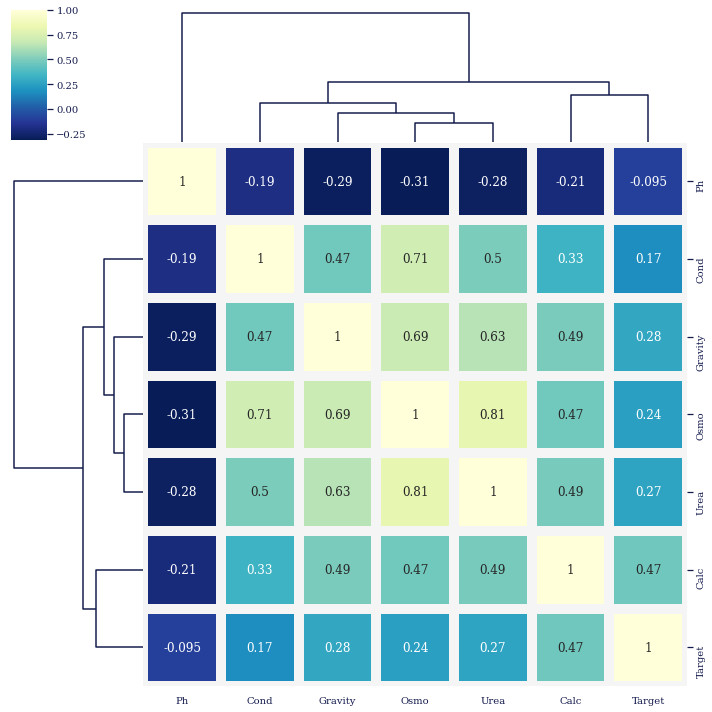

In [8]:
corr = train.corr()

sns.clustermap(
    corr,
    linecolor=BACKGROUND_COLOR,
    linewidth=10,
    annot=True,
    cmap="YlGnBu_r",
    tree_kws={"linewidths": 1.5, "color": "#141B4D"},
    annot_kws={"fontsize": 12},
    figsize=(10, 10),
)
plt.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>The most important for us is obviously <code>Target</code>. We can see it correlates quite well with <code>Calc</code>. The correlation coefficient is around $0.47$.</li>
        <li>There we have at least four interesting pairs yet - <code>Cond</code> vs <code>Osmo</code> ($0.71$), <code>Gravity</code> vs <code>Osmo</code> ($0.69$), <code>Gravity</code> vs <code>Urea</code> ($0.63$) and <code>Osmo</code> vs <code>Urea</code> ($0.81$) (the highest correlation coefficient at all).
        <li>Let's see these correlations over pair plots.</li>
    </ul>
</blockquote>

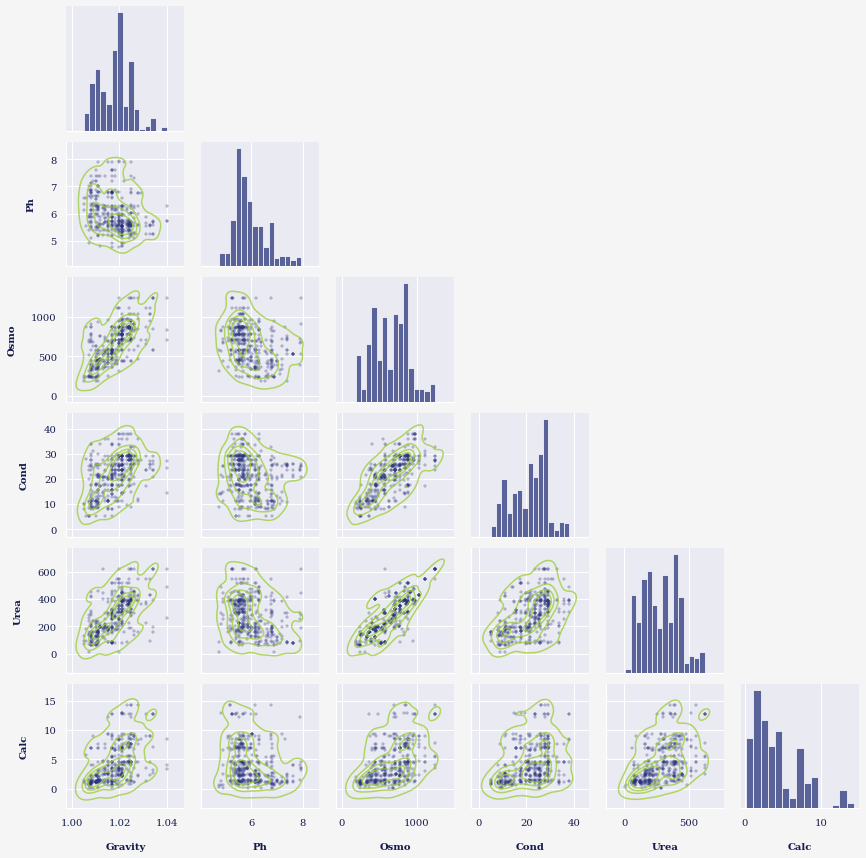

In [9]:
grid = sns.PairGrid(train.drop("Target", axis=1), diag_sharey=False, corner=True)

grid.fig.set_facecolor(BACKGROUND_COLOR)
grid.fig.set_size_inches(12, 12)

grid.map_diag(sns.histplot, color="#2a357d", bins=15)
grid.map_lower(sns.scatterplot, color="#2a357d", marker="+", s=15)
grid.map_lower(sns.kdeplot, levels=5, color="#9acd32", alpha=0.75)

plt.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Here we have clearly visible linear dependency between <code>Cond</code> vs <code>Osmo</code> ($0.71$) and <code>Osmo</code> vs <code>Urea</code> ($0.81$), as we have read from the clustermap.</li>
        <li>Let's see distributions regarding target value.</li>
    </ul>
</blockquote>

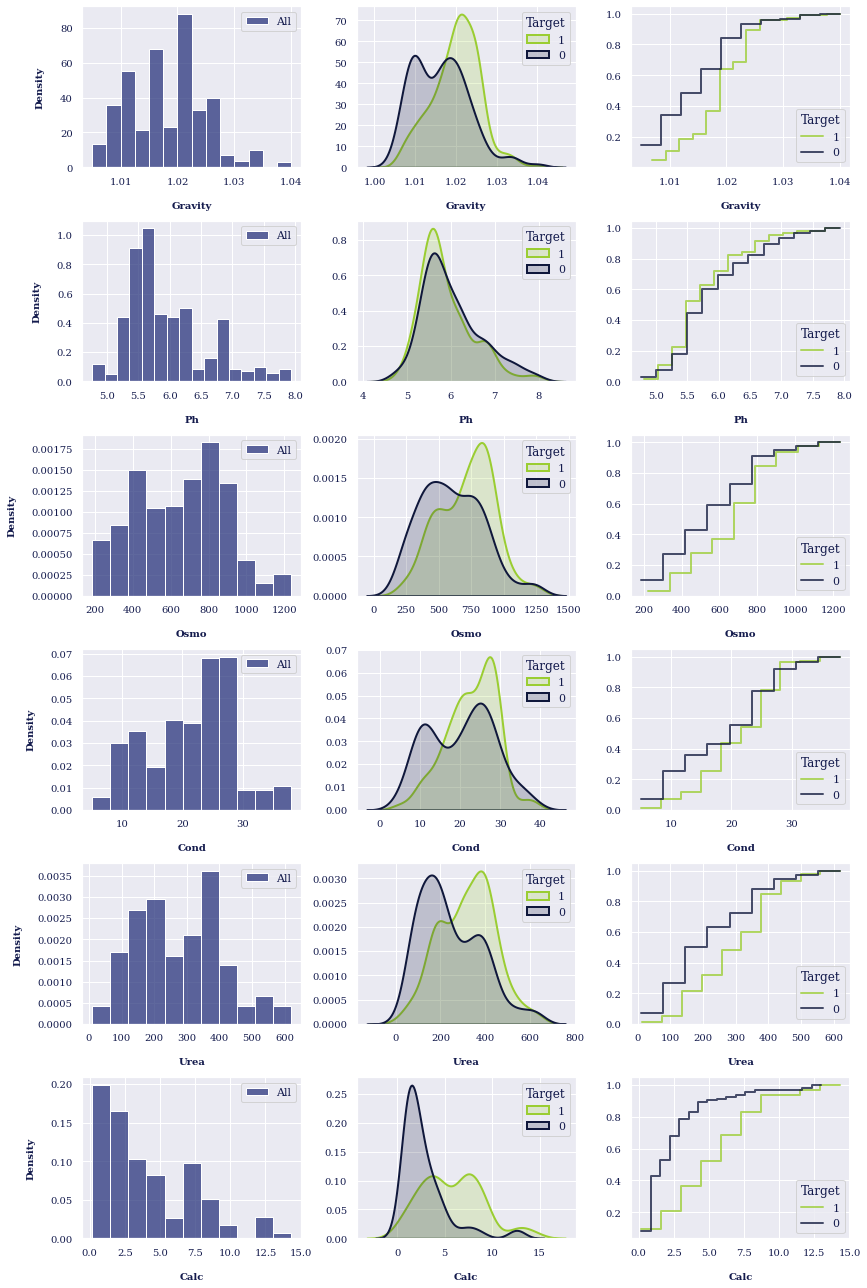

In [10]:
target_true = train["Target"] == 1
features = ["Gravity", "Ph", "Osmo", "Cond", "Urea", "Calc"]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 18), tight_layout=True)
kde_kw = dict(fill=True, linewidth=2, alpha=0.2)
hist_kw = dict(
    linewidth=2, alpha=0.75, element="step", fill=False, cumulative=True, stat="density"
)

for feature, ax in zip(features, axes):
    full = train[feature]
    target1 = train.loc[target_true, feature]
    target0 = train.loc[~target_true, feature]

    plt.sca(ax[0])
    sns.histplot(x=full, color="#2a357d", stat="density", label="All", alpha=0.75)
    plt.legend(loc="upper right")

    plt.sca(ax[1])
    sns.kdeplot(x=target1, color="#9acd32", label="1", **kde_kw)
    sns.kdeplot(x=target0, color="#0f173b", label="0", **kde_kw)
    plt.ylabel("")
    plt.legend(loc="upper right", title="Target")

    plt.sca(ax[2])

    sns.histplot(x=target1, color="#9acd32", label="1", **hist_kw)
    sns.histplot(x=target0, color="#0f173b", label="0", **hist_kw)
    plt.legend(loc="lower right", title="Target")
    plt.ylabel("")

plt.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>It is visible that distributions are different regarding kidney presence (target). The significant difference is present in <code>Calc</code> feature. As we remember, this attribute has the highest correlation with the target ($0.47$).</li>
        <li>On the other hand, the <code>Ph</code> distribution is almost the same in both cases.</li>
    </ul>
</blockquote>

# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Distributions &amp; Pivot Tables</p>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>In this section, we will take a closer look at each feature and create pivot tables which answer the question of which values are more related to the target.</li>
        <li>But let's see the target first.</li>
    </ul>
</blockquote>

In [11]:
df = train.copy()
df["Target"] = df["Target"].map({0: "False", 1: "True"})

fig = px.pie(
    df,
    names="Target",
    height=500,
    width=800,
    hole=0.65,
    title="Target Overview",
    color_discrete_sequence=["#0f173b", "#9acd32"],
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    showlegend=False,
)
fig.add_annotation(
    dict(
        x=0.5,
        y=0.5,
        align="center",
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=22,
        text="Kidney Stones<br>Presence",
    )
)
fig.update_traces(
    opacity=0.75,
    hovertemplate=None,
    textposition="outside",
    textinfo="percent+label",
    textfont_size=16,
    rotation=50,
)
fig.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Fair enough.</li>
    </ul>
</blockquote>

In [12]:
fig = px.histogram(
    train,
    x="Gravity",
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=600,
    width=800,
    title="Gravity vs Target",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
)
fig.update_traces(opacity=0.75)
fig.show()


In [13]:
agg_func_mapper = {
    "mean": "MeanKidneyStonesPresence",
    "sum": "SamplesWithKidney",
    "count": "SamplesTotal",
}

gravity_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Gravity"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

gravity_pivot


,MeanKidneyStonesPresence,SamplesWithKidney,SamplesTotal
Gravity,,,
"(1.004, 1.008]",0.209302,9,43
"(1.008, 1.011]",0.196429,11,56
"(1.011, 1.014]",0.451613,14,31
"(1.014, 1.017]",0.385714,27,70
"(1.017, 1.018]",0.428571,6,14
"(1.018, 1.02]",0.414634,17,41
"(1.02, 1.021]",0.666667,34,51
"(1.021, 1.024]",0.581395,25,43
"(1.024, 1.025]",0.733333,22,30


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Generally, the higher the <code>Gravity</code>, the higher chance of kidney stones presence.</li>
    </ul>
</blockquote>

In [14]:
fig = px.histogram(
    train,
    x="Ph",
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=600,
    width=800,
    title="Ph vs Target",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
)
fig.update_traces(opacity=0.75)
fig.show()


In [15]:
ph_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Ph"], 10, precision=2),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

ph_pivot


,MeanKidneyStonesPresence,SamplesWithKidney,SamplesTotal
Ph,,,
"(4.75, 5.33]",0.478261,22,46
"(5.33, 5.51]",0.488889,22,45
"(5.51, 5.53]",0.500000,17,34
"(5.53, 5.66]",0.531915,25,47
"(5.66, 5.74]",0.461538,18,39
"(5.74, 5.94]",0.421053,16,38
"(5.94, 6.19]",0.375000,18,48
"(6.19, 6.43]",0.441176,15,34
"(6.43, 6.81]",0.441860,19,43


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Regarding <code>Ph</code>, it's hard to say whether lower or higher values are related to kidney presence.</li>
    </ul>
</blockquote>

In [16]:
fig = px.histogram(
    train,
    x="Osmo",
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=600,
    width=800,
    title="Osmo vs Target",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
)
fig.update_traces(opacity=0.75)
fig.show()

In [17]:
osmo_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Osmo"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

osmo_pivot


,MeanKidneyStonesPresence,SamplesWithKidney,SamplesTotal
Osmo,,,
"(186.999, 343.6]",0.142857,6,42
"(343.6, 442.0]",0.391304,18,46
"(442.0, 487.0]",0.315789,12,38
"(487.0, 577.0]",0.392857,22,56
"(577.0, 679.5]",0.400000,10,25
"(679.5, 724.2]",0.512195,21,41
"(724.2, 781.0]",0.478261,22,46
"(781.0, 866.0]",0.589744,23,39
"(866.0, 925.2]",0.666667,26,39


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>In the case of <code>Osmo</code>, the issue is similar to the <code>Gravity</code>, i.e. the higher the <code>Osmo</code>, the higher chance of kidney stones presence.</li>
    </ul>
</blockquote>

In [18]:
fig = px.histogram(
    train,
    x="Cond",
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=600,
    width=800,
    title="Cond vs Target",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
)
fig.update_traces(opacity=0.75)
fig.show()

In [19]:
cond_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Cond"], 10, precision=2),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

cond_pivot


,MeanKidneyStonesPresence,SamplesWithKidney,SamplesTotal
Cond,,,
"(5.09, 10.9]",0.159091,7,44
"(10.9, 13.76]",0.205128,8,39
"(13.76, 17.7]",0.466667,21,45
"(17.7, 20.8]",0.652174,30,46
"(20.8, 22.2]",0.527778,19,36
"(22.2, 24.5]",0.384615,15,39
"(24.5, 26.0]",0.400000,18,45
"(26.0, 27.9]",0.650000,26,40
"(27.9, 29.0]",0.644444,29,45


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>In the case of <code>Cond</code>, the issue is rather mixed. </li>
    </ul>
</blockquote>

In [20]:
fig = px.histogram(
    train,
    x="Urea",
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=600,
    width=800,
    title="Urea vs Target",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
)
fig.update_traces(opacity=0.75)
fig.show()

In [21]:
urea_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Urea"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

urea_pivot


,MeanKidneyStonesPresence,SamplesWithKidney,SamplesTotal
Urea,,,
"(9.999, 95.0]",0.181818,8,44
"(95.0, 159.0]",0.215686,11,51
"(159.0, 187.0]",0.484848,16,33
"(187.0, 214.0]",0.285714,12,42
"(214.0, 277.0]",0.405405,15,37
"(277.0, 315.8]",0.658537,27,41
"(315.8, 380.0]",0.510638,24,47
"(380.0, 395.0]",0.575000,23,40
"(395.0, 443.0]",0.605263,23,38


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Regarding <code>Urea</code>, it's clearly visible that the higher the <code>Urea</code>, the higher chance of kidney stones presence.</li>
    </ul>
</blockquote>

In [22]:
fig = px.histogram(
    train,
    x="Calc",
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=600,
    width=800,
    title="Calc vs Target",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
)
fig.update_traces(opacity=0.75)
fig.show()

In [23]:
calc_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Calc"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

calc_pivot


,MeanKidneyStonesPresence,SamplesWithKidney,SamplesTotal
Calc,,,
"(0.169, 1.053]",0.261905,11,42
"(1.053, 1.27]",0.078431,4,51
"(1.27, 1.548]",0.064516,2,31
"(1.548, 2.336]",0.238095,10,42
"(2.336, 3.13]",0.390244,16,41
"(3.13, 3.98]",0.428571,18,42
"(3.98, 4.74]",0.604651,26,43
"(4.74, 6.99]",0.804878,33,41
"(6.99, 8.515]",0.794872,31,39


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>The difference is the most visible in the case of <code>Calc</code>. Also, the correlation coefficient is the highest here, as we remember.</li>
        <li>The <code>Calc</code> and <code>Gravity</code> have the highest correlation with the target, so let's look at the multilevel pivot table yet.</li>
    </ul>
</blockquote>

In [24]:
calc_pivot = (
    train.pivot_table(
        values="Target",
        index=(
            pd.qcut(train["Calc"], 4),
            pd.qcut(train["Gravity"], 4),
        ),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP2)
)

calc_pivot


# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Probability Plots</p>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>In this section, we will create probability plots. It's a useful tool to see whether given values come from the normal distribution (or from another specified).</li>
    </ul>
</blockquote>

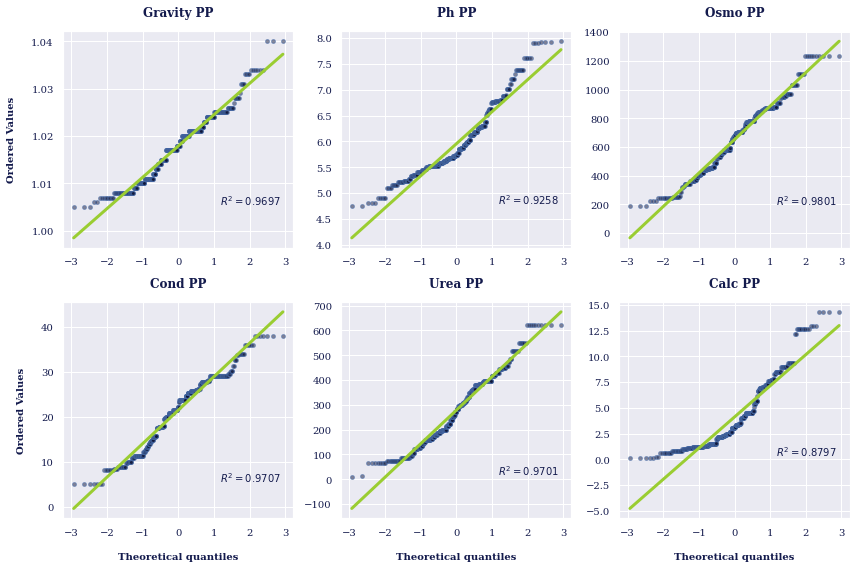

In [25]:
from scipy.stats import probplot

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8), tight_layout=True
)

for ax, feature in zip((ax1, ax2, ax3, ax4, ax5, ax6), features):
    probplot(train[feature], plot=ax, rvalue=True)
    plt.sca(ax)
    plt.title(f"{feature} PP", fontsize=12)
    if ax not in (ax1, ax4):
        plt.ylabel("")
    if ax in (ax1, ax2, ax3):
        plt.xlabel("")

    ax.get_lines()[0].set_markerfacecolor("#0f173b")
    ax.get_lines()[0].set_markersize(4.0)
    ax.get_lines()[0].set_alpha(0.5)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.get_lines()[1].set_color("#9acd32")

plt.show()


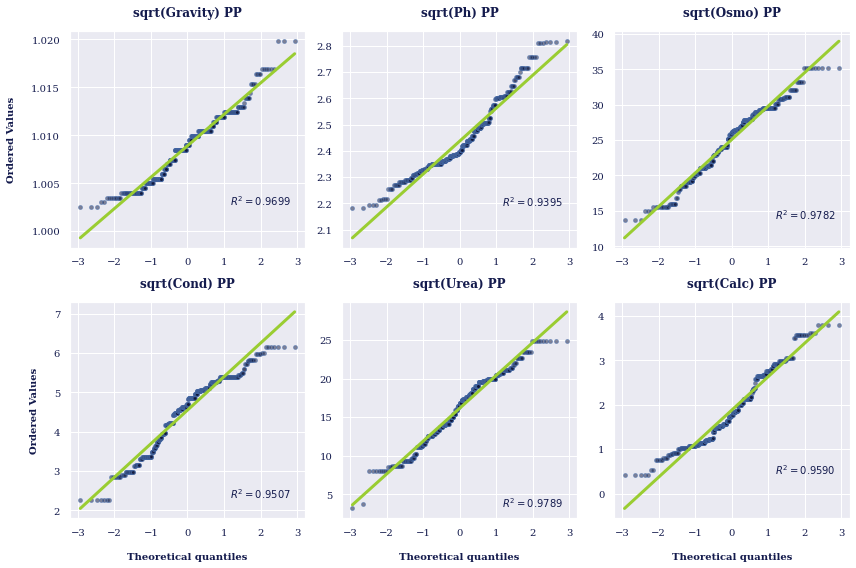

In [26]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8), tight_layout=True
)

for ax, feature in zip((ax1, ax2, ax3, ax4, ax5, ax6), features):
    probplot(np.sqrt(train[feature]), plot=ax, rvalue=True)
    plt.sca(ax)
    plt.title(f"sqrt({feature}) PP", fontsize=12)
    if ax not in (ax1, ax4):
        plt.ylabel("")
    if ax in (ax1, ax2, ax3):
        plt.xlabel("")

    ax.get_lines()[0].set_markerfacecolor("#0f173b")
    ax.get_lines()[0].set_markersize(4.0)
    ax.get_lines()[0].set_alpha(0.5)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.get_lines()[1].set_color("#9acd32")

plt.show()

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>As we can see, almost all features fit the normal distribution, which is manifested by a high coefficient of determination (R-squared) and evenly deployed samples around the green line.</li>
        <li>We have only one worse result - in <code>Calc</code>. As we remember, this feature correlates with the target even more than the others.</li>
        <li>We can slightly improve fit with squared-root transformation for <code>Ph</code> and <code>Urea</code>. Meanwhile, it significantly helps with <code>Calc</code>, where R-squared rises from $0.8797$ to $0.9590$. In other cases, it's not worth using that transformation since results stay the same or are slightly worse.</li>
    </ul>
</blockquote>

# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">3D Projection with TSNE</p>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>TSNE is an excellent tool for visualizing datasets in 2D and 3D. Let's have a look whether samples are separable in 3D.</li>
    </ul>
</blockquote>

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


y = train["Target"].astype("category")
X = train.drop("Target", axis=1)

scaler = StandardScaler()
X_full = scaler.fit_transform(X)
y_full = y

tsne = TSNE(n_components=3, random_state=42, learning_rate="auto", init="pca")

X3D = tsne.fit_transform(X_full)
X3D = pd.DataFrame(X3D, columns=["x1", "x2", "x3"], index=y.index).join(y)
X3D.head()


,x1,x2,x3,Target
id,,,,
0,-6.099107,1.600500,1.207038,0
1,3.500572,1.241468,-1.711928,0
2,-0.981533,0.645460,3.257920,0
3,1.963175,1.789349,0.855089,1
4,4.129233,2.697797,-1.818716,1


In [28]:
fig = px.scatter_3d(
    data_frame=X3D,
    x="x1",
    y="x2",
    z="x3",
    symbol="Target",
    symbol_sequence=["circle", "diamond"],
    color="Target",
    color_discrete_sequence=["#0f173b", "#9acd32"],
    opacity=0.6,
    height=700,
    width=800,
    title="Training Dataset - 3D projection with t-SNE",
)

fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)

fig.update_traces(marker_size=4)
fig.show()

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Unfortunately, they are not separable. However, we can spot something like two clusters.</li>
    </ul>
</blockquote>

# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Feature Importance</p>

<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>Let's see the feature importance with different methods. We'll look at how a simple decision tree makes decisions, and then we will see a more sophisticated approach with <code>LDA</code>, <code>RandomForestClassifier</code> and <code>mutual_info_classif</code>.</li>
    </ul>
</blockquote>

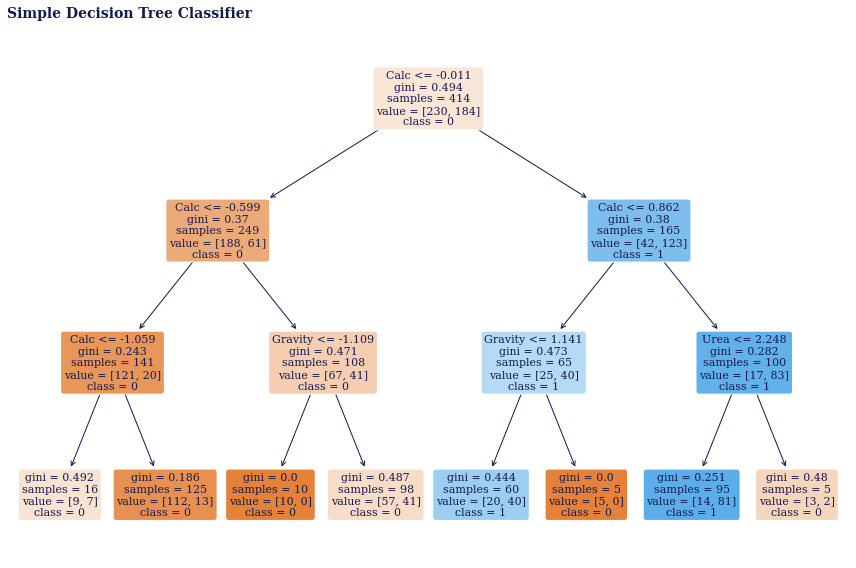

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


feature_names_out = scaler.get_feature_names_out()

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_full, y_full)
y_classes = tree_clf.classes_.astype(str)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
plot_tree(
    decision_tree=tree_clf,
    feature_names=feature_names_out,
    class_names=y_classes,
    filled=True,
    rounded=True,
    ax=ax,
    fontsize=11,
)
plt.title("Simple Decision Tree Classifier", loc="left")
plt.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>As we can see, this tree decides concerning <code>Calc</code>, <code>Gravity</code> and <code>Urea</code>. This should not surprise us too much since these features have the highest correlation with the target.</li>
        <li>Now let's have a look at <code>LDA</code>, <code>RandomForestClassifier</code> and <code>mutual_info_classif</code>.</li>
    </ul>
</blockquote>

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif


lda = LinearDiscriminantAnalysis()
lda.fit(X_full, y_full)
lda_info = np.abs(lda.scalings_.ravel())
lda_info = lda_info / lda_info.sum()

forest = RandomForestClassifier(random_state=42)
forest.fit(X_full, y_full)
forest_info = forest.feature_importances_

mutual_info = mutual_info_classif(X_full, y_full, random_state=42)
mutual_info = mutual_info / np.sum(mutual_info)

importances = pd.DataFrame(
    [lda_info, forest_info, mutual_info],
    columns=feature_names_out,
    index=["LDA", "Random Forest", "Mutual Information"],
).T

importances = importances.loc[
    importances.mean(axis=1).sort_values(ascending=False).index
]

importances.style.background_gradient(DF_CMAP2)


,LDA,Random Forest,Mutual Information
Calc,0.679945,0.318023,0.408215
Gravity,0.118133,0.126566,0.168568
Urea,0.075680,0.146049,0.177041
Osmo,0.080630,0.118153,0.114343
Cond,0.015892,0.137563,0.131832
Ph,0.029719,0.153647,0.000000


In [31]:
melted = (
    importances.melt(
        var_name="Method",
        value_name="Importance",
        ignore_index=False,
    )
    .reset_index()
    .rename(columns={"index": "Feature"})[::-1]
)

fig = px.bar(
    data_frame=melted,
    x="Importance",
    y="Feature",
    color="Method",
    barmode="group",
    height=550,
    width=800,
    color_discrete_sequence=px.colors.diverging.Earth_r,
    title="Normalised Feature Importances",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>As you see, different methods give different results, but the general trend is undoubtedly visible. According to all methods, the <code>Calc</code> feature is the most important.</li>
        <li>Let's stay with the feature importance problem and see how the AUC of <code>RandomForestClassifier</code> changes when we randomly permute samples in a specific attribute since random permutation of variable results in removing all predictive power for this attribute.</li>
    </ul>
</blockquote>

In [32]:
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
forest = RandomForestClassifier(random_state=42)
auc_scores = defaultdict(list)
np.random.seed(42)

for k, (train_ids, valid_ids) in enumerate(skfold.split(X, y)):

    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    forest.fit(X_train, y_train)
    auc = roc_auc_score(y_valid, forest.predict_proba(X_valid)[:, 1])

    for i, feature in enumerate(feature_names_out):
        X_shuffled = X_valid.copy()
        X_shuffled[:, i] = np.random.permutation(X_shuffled[:, i])
        auc_shuffled = roc_auc_score(y_valid, forest.predict_proba(X_shuffled)[:, 1])
        auc_scores[feature].append((auc - auc_shuffled) / auc)

    print(CLR + "Fold:", f"{BLUE}{k}", f"\t{CLR}Baseline AUC: {BLUE}{auc:.3f}")


Fold: 0 	Baseline AUC: 0.713
Fold: 1 	Baseline AUC: 0.705
Fold: 2 	Baseline AUC: 0.828
Fold: 3 	Baseline AUC: 0.828
Fold: 4 	Baseline AUC: 0.833
Fold: 5 	Baseline AUC: 0.849
Fold: 6 	Baseline AUC: 0.838
Fold: 7 	Baseline AUC: 0.781
Fold: 8 	Baseline AUC: 0.773
Fold: 9 	Baseline AUC: 0.835


In [33]:
auc_decrease_df = (
    pd.DataFrame(auc_scores)
    .mean()
    .sort_values()
    .to_frame(name="Mean AUC Decrease")
    .reset_index()
    .rename(columns={"index": "Feature"})
)

fig = px.bar(
    data_frame=auc_decrease_df,
    x="Mean AUC Decrease",
    y="Feature",
    height=550,
    width=800,
    color="Mean AUC Decrease",
    color_continuous_scale=px.colors.diverging.Earth,
    title="Random Forest - Mean AUC Decrease within Samples Permutation",
)
fig.update_layout(
    font=dict(color=FONT_COLOR),
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>The result is huge, as you can see. Random permutation of samples in <code>Calc</code> leads to a vast AUC decrease. Meanwhile, in other features, the outcome is negligible.</li>
        <li>Moreover, this method is based on out-of-bag data, so it is more accurate than the Gini impurity decrease.</li>
        <li>Let's see at partial dependence plots yet.</li>
    </ul>
</blockquote>

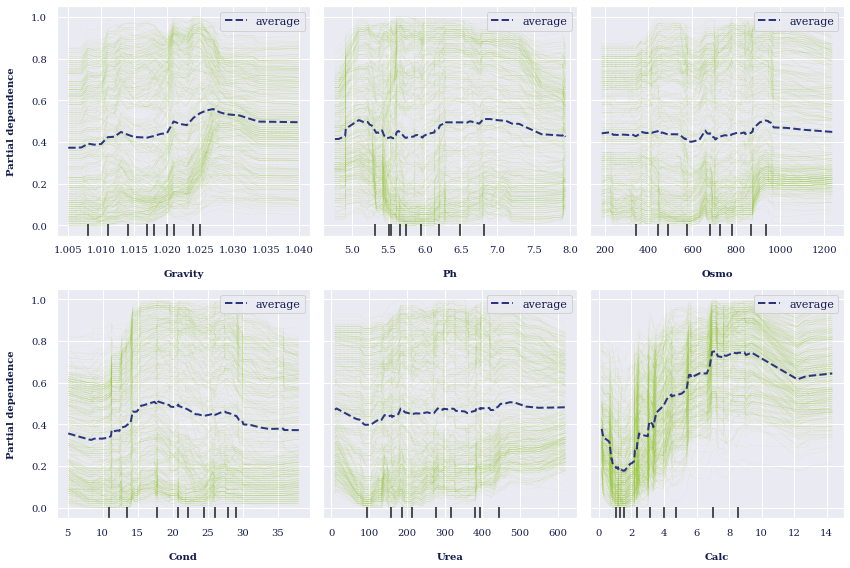

In [46]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

forest = RandomForestClassifier(random_state=42)
forest.fit(X, y)

fig, axes = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True, sharey=True)

PartialDependenceDisplay.from_estimator(
    forest,
    X,
    features,
    response_method="predict_proba",
    kind="both",
    percentiles=(0, 1),
    ice_lines_kw={"color": "#9acd32", "linewidth": 0.25, "alpha": 0.25, "linestyle": "--"},
    pd_line_kw={"color": "#2a357d", "linewidth": 2.0},
    ax=axes.ravel(),
)

for ax in axes.ravel():
    ax.legend(loc="upper right")
    if ax not in (axes[0, 0], axes[1, 0]):
        ax.set_ylabel("")

plt.show()


<p style="font-size:20px; font-family:JetBrains Mono; color:#3E3F4C; border-bottom: 3px solid #2a357d">Notes 📜</p>
<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 10px; margin-top: 2px; margin-bottom: 2px">
        <li>In general partial dependence plot (PDP) is another tool for visualizing the feature's importance. However, this approach differs slightly from the earlier depicted. Here, the partial dependence plot shows the relationship between the model outcome and a particular feature. In this case, the outcome (partial dependence) is a probability of positive class.</li>
        <li>Actually, we've created individual conditional expectation (ICE) plots. It's similar to PDP, but here ICE plot shows the dependency of the prediction
within a given feature for each sample (it means each green line corresponds to a specific sample).</li>
        <li>So, what can we see here? Obviously, the <code>Calc</code> stole the whole show. Positive class probability strongly depends on this feature and, in the range $(2.5, 7.5)$ of <code>Calc</code>, the outcome "linearly" grows. On the other hand, the remaining attributes don't have such predictive power. Maybe only the <code>Gravity</code> and <code>Cond</code> are slightly important yet.</li>
    </ul>
</blockquote>

# <p style="padding:15px; background-color:#fffaf6; font-family:JetBrains Mono; font-weight:bold; color:#3E3F4C; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Summary</p>

<blockquote style="margin-right:auto; margin-left:auto; background-color:#fffaf6; padding: 15px; border-radius: 10px 10px">
    <ul style="font-size:16px; font-family:JetBrains Mono; color:#3E3F4C; margin-right: 15px; margin-top: 2px; margin-bottom: 2px">
        <li>There we have only $414$ samples with six numerical features and binary target.</li>
        <li>There are no missing values and no imputation is needed.</li>
        <li>The target balance is fair enough ($44$% - $56$%).
        <li>The target is mostly correlated with the <code>Calc</code> ($0.47$).</li>
        <li>We have four highly correlated pairs - <code>Cond</code> vs <code>Osmo</code> ($0.71$), <code>Gravity</code> vs <code>Osmo</code> ($0.69$), <code>Gravity</code> vs <code>Urea</code> ($0.63$) and <code>Osmo</code> vs <code>Urea</code> ($0.81$).
        <li>Features fit the normal distribution (high R-squared, usually $>0.90$).</li>
        <li>It's reasonable to transform <code>Calc</code> with a square root. It improves the fit to the normal distribution and R-squared coefficient from $0.8797$ to $0.9590$</li>
        <li>Samples are not easily separable in 3D.</li>
        <li>Feature importance measures make it clear that there is only one relevant attribute - <code>Calc</code>.</li>
    </ul>
</blockquote>